In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Run simulations
num_simulations = 10000
debug = False  # Set to True for detailed debugging output

In [17]:
# Define Heroes
heroes = {
    "Sir Gallant": {
        "hp": 20, "ac": 15, "speed": 30,
        "strength": 2, "dexterity": 3, "constitution": 1, "intelligence": 0, "wisdom": 1, "charisma": -1,
        "actions": [{"name": "Sword Slash", "to_hit": 5, "damage": (1, 8, 2)}],
        "bonus_actions": [],
        "multiattack": 2,
    },
    "Archer Elle": {
        "hp": 18, "ac": 14, "speed": 25,
        "strength": 1, "dexterity": 4, "constitution": 1, "intelligence": 2, "wisdom": 0, "charisma": 0,
        "actions": [{"name": "Bow Shot", "to_hit": 6, "damage": (1, 6, 3)}],
        "bonus_actions": []
    },
    "Mage Arlen": {
        "hp": 16, "ac": 12, "speed": 30,
        "strength": -1, "dexterity": 2, "constitution": 0, "intelligence": 3, "wisdom": 1, "charisma": 0,
        "actions": [{"name": "Firebolt", "to_hit": 6, "damage": (1, 10, 0)}],
        "bonus_actions": [],
        "multiattack": 1,
        "spellcaster": {
            "spell_slots": [2, 2, 1],
            "spells": ["Poison Cloud", "Fireball", "Ice Knife"]
        },
        "spell_dc": 14,
    }

}

In [18]:
# Define Enemies
enemies = {
    "Young Dragon": {
        "hp": 142, "ac": 18, "speed": 40,
        "strength": 5, "dexterity": 0, "constitution": 4, "intelligence": 2, "wisdom": 1, "charisma": 3,
        "actions": [
            {"name": "Bite", "to_hit": 8, "damage": (2, 10, 5)},
            {"name": "Claw", "to_hit": 8, "damage": (2, 6, 5)},
            {
                "name": "Lightning Breath",
                "to_hit": None,
                "damage": (10, 10, 0),
                "save_dc": 15,
                "save_ability": "dexterity",  # Ability used for the save
                "damage_type": "lightning",
            }
        ],
        "bonus_actions": [],
        "multiattack": 3
    },

    "Snake": {
        "hp": 2, "ac": 13, "speed": 30,
        "strength": -4, "dexterity": 3, "constitution": 0, "intelligence": -5, "wisdom": 0, "charisma": -4,
        "actions": [{"name": "Bite", "to_hit": 5, "damage": (1, 1, 0), "extra_effect": {
                "type": "poison",
                "save_dc": 10,
                "save_stat": "constitution",
                "damage": (2, 4, 0),  # Poison damage: 2d4
                "on_save": "half"
            }}],
        "bonus_actions": [],
        "multiattack": 1
    }
}

In [19]:
# Here you should state evey Spell you plan on using and its minimum spell slot level required
SPELLS = {
    "Poison Cloud": {"min_level": 1},
    "Fireball": {"min_level": 3},
    "Ice Knife": {"min_level": 1}
}

In [20]:
# Function to roll dice with disadvantage or advantage
def roll_dice(num, sides, bonus=0, disadvantage=False, advantage=False):
    if bonus is None:
        bonus = 0 # Treat None as 0
    rolls = [sum(np.random.randint(1, sides + 1) for _ in range(num)) + bonus for _ in range(2)]
    if disadvantage:
        return min(rolls)
    elif advantage:
        return max(rolls)
    return rolls[0]

# Apply bonus action effects
def apply_bonus_action(bonus_action, target_stats):
    if bonus_action["effect"] == "frightened":
        dc = bonus_action["dc"]
        stat = bonus_action["stat"]
        save_roll = roll_dice(1, 20, target_stats[stat])
        if save_roll < dc:
            target_stats["frightened"] = True  # Apply frightened condition
            return "frightened"
    return None


# Resolve extra effects like poison
def resolve_extra_effect(effect, target_stats):
    if effect["type"] == "poison":
        save_roll = roll_dice(1, 20, target_stats[effect["save_stat"]])
        if save_roll < effect["save_dc"]:
            damage = roll_dice(*effect["damage"])
        else:
            damage = roll_dice(*effect["damage"]) // 2
        return damage
    return 0

In [21]:
def execute_bonus_action(bonus_action, combatant, target_pool):
    # Choose a random target if applicable
    target = np.random.choice(target_pool) if "target_required" in bonus_action and bonus_action["target_required"] else None

    # Handle bonus action effects
    if bonus_action["name"] == "Frightening Roar":
        save_roll = roll_dice(1, 20, target["stats"]["wisdom"])
        if save_roll >= bonus_action["dc"]:
            return f"{combatant['name']}'s {bonus_action['name']} failed to frighten {target['name']}."
        else:
            # Apply frightened condition
            target["stats"]["frightened"] = True
            return f"{combatant['name']}'s {bonus_action['name']} frightened {target['name']}!"

    elif bonus_action["name"] == "Healing Surge":
        heal_amount = roll_dice(1, 8, 3)  # Example healing logic
        combatant["stats"]["current_hp"] = min(combatant["stats"]["current_hp"] + heal_amount, combatant["stats"]["hp"])
        return f"{combatant['name']} used {bonus_action['name']} and healed {heal_amount} HP!"

    else:
        return f"{combatant['name']} used {bonus_action['name']} but nothing happened."


In [22]:
def cast_spell(combatant, target_pool, debug=False):
    spell_slots = combatant["stats"]["spellcaster"]["spell_slots"]
    available_slots = [i + 1 for i, slots in enumerate(spell_slots) if slots > 0]

    if not available_slots:
        return f"{combatant['name']} has no spell slots remaining!"

    # Filter for castable spells based on available slots
    castable_spells = [spell for spell in combatant["stats"]["spellcaster"]["spells"]
                       if SPELLS[spell]["min_level"] <= max(available_slots)]

    if not castable_spells:
        return f"{combatant['name']} has no spells that can be cast with the available slots!"

    # Choose a random castable spell
    spell_name = np.random.choice(castable_spells)
    spell = SPELLS[spell_name]

    # Determine the highest level slot available for this spell
    spell_level = max((slot for slot in available_slots if slot >= spell["min_level"]), default=None)

    if not spell_level:
        return f"{combatant['name']} cannot cast {spell_name}; no slots of level {spell['min_level']} or higher are available."

    # Consume the spell slot
    spell_slots[spell_level - 1] -= 1

    # Debug message for spellcasting
    if debug:
        print(f"{combatant['name']} is casting {spell_name} at level {spell_level}!")

    # Execute the spell (needs to be expanded for more spells)
    if spell_name == "Poison Cloud":
        target = np.random.choice(target_pool)
        result = cast_poison_cloud(spell_level, spell["min_level"], target)
        return result  # Debug handled earlier
    elif spell_name == "Fireball":
        result = cast_fireball(spell_level, spell["min_level"], target_pool, combatant)
        return result  # Debug handled earlier
    elif spell_name == "Ice Knife":
        # Choose a primary target for piercing damage
        primary_target = np.random.choice(target_pool)
        return cast_ice_knife(spell_level, spell["min_level"], primary_target, target_pool, combatant)

    else:
        return f"{combatant['name']} tried to cast an unknown spell!"


In [23]:
def cast_poison_cloud(spell_level, min_level, target):
    base_dice, base_sides = 2, 8  # Base damage for Poison Cloud
    extra_dice = max(0, spell_level - min_level)  # Scale above the minimum level
    damage = roll_dice(base_dice + extra_dice, base_sides, 0)
    target["stats"]["current_hp"] -= damage
    return f"Poison Cloud hit {target['name']} for {damage} damage!"


def cast_fireball(spell_level, min_level, targets, caster):
    # Base damage for Fireball starts at level 3
    base_dice, base_sides = 8, 6
    extra_dice = max(0, spell_level - min_level)  # Only scale above the minimum level
    total_dice = base_dice + extra_dice

    results = []
    for target in targets:
        # Saving throw logic
        save_roll = roll_dice(1, 20, target["stats"].get("dexterity", 0))
        save_dc = caster["stats"].get("spell_dc", 15)  # Default DC if not specified
        if save_roll >= save_dc:
            damage = roll_dice(total_dice, base_sides, 0) // 2  # Half damage
            results.append(f"{target['name']} succeeded on the save and took {damage} damage!")
        else:
            damage = roll_dice(total_dice, base_sides, 0)  # Full damage
            results.append(f"{target['name']} failed the save and took {damage} damage!")

        target["stats"]["current_hp"] -= damage

    return results

def cast_ice_knife(spell_level, min_level, target, target_pool, caster):
    base_cold_dice, base_cold_sides = 2, 6  # Base cold damage for Ice Knife
    piercing_dice, piercing_sides = 1, 10  # Piercing damage
    extra_cold_dice = max(0, spell_level - min_level)  # Scale cold damage above minimum level
    total_cold_dice = base_cold_dice + extra_cold_dice

    results = []

    # Ranged spell attack for piercing damage
    attack_roll = roll_dice(1, 20, caster["stats"]["dexterity"])
    if attack_roll >= target["stats"]["ac"]:
        piercing_damage = roll_dice(piercing_dice, piercing_sides, 0)
        target["stats"]["current_hp"] -= piercing_damage
        results.append(f"{caster['name']}'s Ice Knife hit {target['name']} for {piercing_damage} piercing damage!")
    else:
        results.append(f"{caster['name']}'s Ice Knife missed {target['name']}!")

    # Cold damage explosion
    cold_damage = roll_dice(total_cold_dice, base_cold_sides, 0)
    targets_in_explosion = [t for t in target_pool if t["stats"]["current_hp"] > 0]  # Include target in AOE
    for aoe_target in targets_in_explosion:
        save_roll = roll_dice(1, 20, aoe_target["stats"].get("dexterity", 0))
        if save_roll >= caster["stats"].get("spell_dc", 15):  # Default DC of 15
            reduced_damage = cold_damage // 2
            aoe_target["stats"]["current_hp"] -= reduced_damage
            results.append(f"{aoe_target['name']} succeeded on the save and took {reduced_damage} cold damage!")
        else:
            aoe_target["stats"]["current_hp"] -= cold_damage
            results.append(f"{aoe_target['name']} failed the save and took {cold_damage} cold damage!")

    return results

In [24]:
def execute_action(action, combatant, target_pool):
    # Choose a random target
    target = np.random.choice(target_pool)

    # Handle automatic hit
    if action.get("effect") == "automatic_hit":
        damage = roll_dice(*action["damage"])
        target["stats"]["current_hp"] -= damage
        return f"{combatant['name']}'s {action['name']} hit {target['name']} automatically for {damage} damage!"

    # Handle regular attack
    if action.get("to_hit") is not None:
        attack_roll = roll_dice(1, 20, action["to_hit"])
        if attack_roll >= target["stats"]["ac"]:
            damage = roll_dice(*action["damage"])
            target["stats"]["current_hp"] -= damage
            return f"{combatant['name']}'s {action['name']} hit {target['name']} for {damage} damage!"
        else:
            return f"{combatant['name']}'s {action['name']} missed {target['name']}!"

    # Handle saving throw (e.g., breath weapon)
    if action.get("save_dc"):
        save_ability = action.get("save_ability", "dexterity")  # Default to dexterity if not provided
        save_modifier = target["stats"].get(save_ability, 0)
        save_roll = roll_dice(1, 20, save_modifier)
        if save_roll >= action["save_dc"]:
            damage = roll_dice(*action["damage"]) // 2  # Half damage on success
            target["stats"]["current_hp"] -= damage
            return f"{combatant['name']}'s {action['name']} hit {target['name']} for {damage} {action['damage_type']} damage (save succeeded)!"
        else:
            damage = roll_dice(*action["damage"])  # Full damage on failure
            target["stats"]["current_hp"] -= damage
            return f"{combatant['name']}'s {action['name']} hit {target['name']} for {damage} {action['damage_type']} damage (save failed)!"


In [25]:
def simulate_fight(heroes, enemies, debug=False):
    combatants = []

    # Prepare initiative order
    for hero_name, hero in heroes.items():
        # Reset spell slots
        if "spellcaster" in hero:
            hero["spellcaster"]["spell_slots"] = [2, 2, 1]  # Reset to original spell slots

        # Reset HP and other stats
        hero["current_hp"] = hero["hp"]

        initiative = roll_dice(1, 20, hero["dexterity"])
        combatants.append({"type": "hero", "name": hero_name, "stats": hero, "initiative": initiative})

    for enemy_name, enemy in enemies.items():
        # Reset HP
        enemy["current_hp"] = enemy["hp"]

        initiative = roll_dice(1, 20, enemy["dexterity"])
        combatants.append({"type": "enemy", "name": enemy_name, "stats": enemy, "initiative": initiative})

    # Sort combatants by initiative
    combatants.sort(key=lambda x: x["initiative"], reverse=True)

    while True:
        # Check if the battle is over
        heroes_alive = any(c["type"] == "hero" and c["stats"]["current_hp"] > 0 for c in combatants)
        enemies_alive = any(c["type"] == "enemy" and c["stats"]["current_hp"] > 0 for c in combatants)
        if not heroes_alive or not enemies_alive:
            break

        for combatant in list(combatants):  # Iterate over a copy
            if combatant["stats"]["current_hp"] <= 0:
                continue  # Skip dead combatants

            # Determine target pool
            target_pool = [t for t in combatants if t["type"] != combatant["type"] and t["stats"]["current_hp"] > 0]
            if not target_pool:
                continue  # No valid targets

            # Execute primary action
            if "spellcaster" in combatant["stats"]:
                spell_result = cast_spell(combatant, target_pool, debug=debug)
                if debug:
                    if isinstance(spell_result, list):  # For multi-target spells like Fireball
                        for result in spell_result:
                            print(result)
                    else:
                        print(spell_result)

            else:
                # Regular attack or special action
                action = np.random.choice(combatant["stats"]["actions"])
                action_result = execute_action(action, combatant, target_pool)
                if debug:
                    print(action_result)

            # Execute bonus actions if available
            if "bonus_actions" in combatant["stats"]:
                for bonus_action in combatant["stats"]["bonus_actions"]:
                    bonus_result = execute_bonus_action(bonus_action, combatant, target_pool)
                    if debug:
                        print(bonus_result)

    # Determine outcome
    if heroes_alive and not enemies_alive:
        return 1  # Heroes win
    elif enemies_alive and not heroes_alive:
        return 0  # Enemies win
    else:
      return 0

In [26]:
def monte_carlo_simulation(heroes, enemies, num_simulations, debug):
    total_wins = 0

    for _ in range(num_simulations):
        total_wins += simulate_fight(heroes, enemies, debug)

    total_losses = num_simulations - total_wins
    return {"wins": total_wins, "losses": total_losses}

Total Wins: 3
Total Losses: 9997


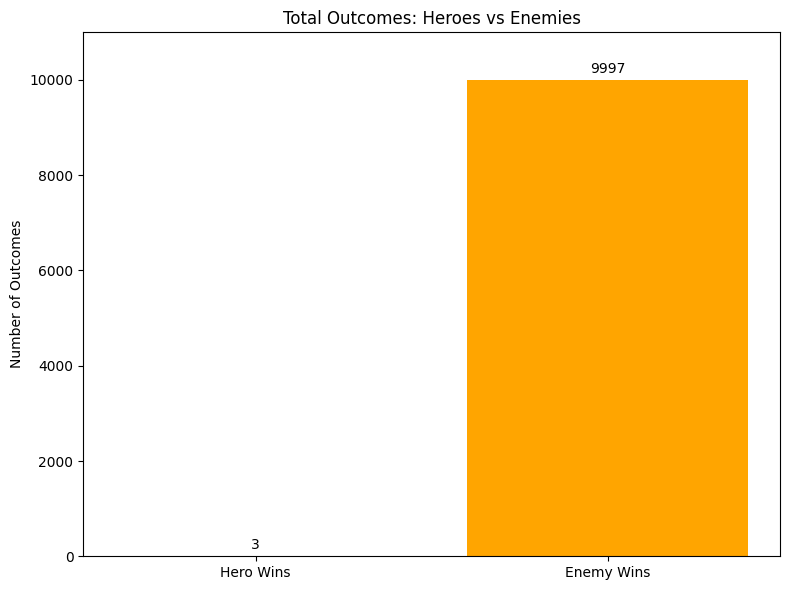

In [27]:
if debug:
    num_simulations = 1

results = monte_carlo_simulation(heroes, enemies, num_simulations, debug)

# Print results
print(f"Total Wins: {results['wins']}")
print(f"Total Losses: {results['losses']}")

# Visualization of results
categories = ["Hero Wins", "Enemy Wins"]
data = [results["wins"], results["losses"]]

fig, ax = plt.subplots(figsize=(8, 6))
rects = ax.bar(categories, data, color=["purple", "orange"])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Outcomes')
ax.set_title('Total Outcomes: Heroes vs Enemies')
ax.set_ylim(0, num_simulations + (num_simulations * 0.1))

# Attach a text label above each bar, displaying its height
for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()